In [1]:
import copy
import os
import random
import sys
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

# Hyper Parameters
batch_size = 24
num_classes = 5  # 5 DR levelsA
learning_rate = 0.0001
num_epochs = 25


In [2]:

class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, mode='single', test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform

        self.test = test
        self.mode = mode

        if self.mode == 'single':
            self.data = self.load_data()
        else:
            self.data = self.load_data_dual()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == 'single':
            return self.get_item(index)
        else:
            return self.get_item_dual(index)

    # 1. single image
    def load_data(self):
        df = pd.read_csv(self.ann_file)

        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['img_path'])
            if not self.test:
                file_info['dr_level'] = int(row['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return img, label
        else:
            return img

    # 2. dual image
    def load_data_dual(self):
        df = pd.read_csv(self.ann_file)

        df['prefix'] = df['image_id'].str.split('_').str[0]  # The patient id of each image
        df['suffix'] = df['image_id'].str.split('_').str[1].str[0]  # The left or right eye
        grouped = df.groupby(['prefix', 'suffix'])

        data = []
        for (prefix, suffix), group in grouped:
            file_info = dict()
            file_info['img_path1'] = os.path.join(self.image_dir, group.iloc[0]['img_path'])
            file_info['img_path2'] = os.path.join(self.image_dir, group.iloc[1]['img_path'])
            if not self.test:
                file_info['dr_level'] = int(group.iloc[0]['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item_dual(self, index):
        data = self.data[index]
        img1 = Image.open(data['img_path1']).convert('RGB')
        img2 = Image.open(data['img_path2']).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return [img1, img2], label
        else:
            return [img1, img2]


class CutOut(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if np.random.rand() > self.p:
            return img

        # Ensure the image is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError('Input image must be a torch.Tensor')

        # Get height and width of the image
        h, w = img.shape[1], img.shape[2]
        mask_size_half = self.mask_size // 2
        offset = 1 if self.mask_size % 2 == 0 else 0

        cx = np.random.randint(mask_size_half, w + offset - mask_size_half)
        cy = np.random.randint(mask_size_half, h + offset - mask_size_half)

        xmin, xmax = cx - mask_size_half, cx + mask_size_half + offset
        ymin, ymax = cy - mask_size_half, cy + mask_size_half + offset
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)

        img[:, ymin:ymax, xmin:xmax] = 0
        return img


class SLORandomPad:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        pad_width = max(0, self.size[0] - img.width)
        pad_height = max(0, self.size[1] - img.height)
        pad_left = random.randint(0, pad_width)
        pad_top = random.randint(0, pad_height)
        pad_right = pad_width - pad_left
        pad_bottom = pad_height - pad_top
        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom))


class FundRandomRotate:
    def __init__(self, prob, degree):
        self.prob = prob
        self.degree = degree

    def __call__(self, img):
        if random.random() < self.prob:
            angle = random.uniform(-self.degree, self.degree)
            return transforms.functional.rotate(img, angle)
        return img

class GaussianBlur:
    def __init__(self, kernel_size=(5, 5), sigma=(0.1, 2.0)):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        if random.random() > 0.5:  # Apply Gaussian Blur with 50% probability
            return transforms.functional.gaussian_blur(img, kernel_size=self.kernel_size, sigma=random.uniform(*self.sigma))
        return img


class CLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        if random.random() > 0.5:  # Apply CLAHE with 50% probability
            img_np = np.array(img)
            img_lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(img_lab)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            l = clahe.apply(l)
            img_lab = cv2.merge((l, a, b))
            img_np = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
            return Image.fromarray(img_np)
        return img


transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Add Gaussian Blur
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),  # Add CLAHE for enhanced contrast
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.AutoAugment(interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

"""
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
"""
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='model.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score
    train_losses = []
    eval_losses = []
    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)
        train_losses.append(epoch_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Evaluation on the validation set at the end of each epoch
        eval_loss, val_metrics = evaluate_model(model, val_loader, device,criterion)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]
        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f}')
        eval_losses.append(eval_loss)

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    return model, train_losses, eval_losses

def evaluate_model(model, test_loader, device, criterion, test_only=False, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []
    eval_loss = 0.0
    total_samples = 0

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):
            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            if not test_only:
                labels = labels.to(device)

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

                if not test_only:
                    # Calculate loss
                    loss = criterion(outputs, labels)
                    eval_loss += loss.item() * labels.size(0)
                    total_samples += labels.size(0)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.cpu().numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.cpu().numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        eval_loss /= total_samples  # Calculate mean loss
        metrics = compute_metrics(all_preds, all_labels)
        return eval_loss, metrics



def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall


class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet34(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x


class MyDualModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.resnet18(pretrained=True)
        backbone.fc = nn.Identity()

        # Here the two backbones will have the same structure but unshared weights
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1(image1)
        x2 = self.backbone2(image2)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x


In [3]:
if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Create datasets

    train_dir = "/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/DeepDRiD/train/"
    train_ann_file = "/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/DeepDRiD/train.csv"
    val_dir = "/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/DeepDRiD/val/"
    val_ann_file = "/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/DeepDRiD/val.csv"
    test_dir = "/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/DeepDRiD/test"
    test_ann_file = "/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/DeepDRiD/test.csv"

    train_dataset = RetinopathyDataset(ann_file=train_ann_file, image_dir=train_dir, mode=mode, transform=transform_train)
    val_dataset = RetinopathyDataset(ann_file=val_ann_file, image_dir=val_dir, mode=mode, transform=transform_test)
    test_dataset = RetinopathyDataset(ann_file=test_ann_file, image_dir=test_dir, mode=mode, transform=transform_test, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    state_dict_path = "/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/results/res_d/resnet34_pth/model.pth"
    state_dict = torch.load(state_dict_path, map_location=device)
    model.load_state_dict(state_dict, strict=True)
    model = model.to(device)

    # # Freeze all layers except the final fully connected (fc) layer
    # for param in model.backbone.parameters():
    #     param.requires_grad = False

    # # Ensure only the `fc` layer is trainable
    # for param in model.fc.parameters():
    #     param.requires_grad = True


    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    #Train and evaluate the model with the training and validation set
    model, tl, el = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path= '/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/results/res_d/train_with_DeepDRiD/res34_APTOS_deepDRiD.pth'
    )

    # # Load the pretrained checkpoint
    state_dict = torch.load('/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/results/res_d/train_with_DeepDRiD/res34_APTOS_deepDRiD.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # # Make predictions on testing set and save the prediction results
    pred_path = "/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/results/res_d/train_with_DeepDRiD/predictions.csv"
    evaluate_model(model, test_loader, device, test_only=True, prediction_path=pred_path)

/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

/var/folders/2s/t87m92j14g9b1yw35n324r5w0000gn/T/ipykernel_92234/3817809042.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path, map


Epoch 1/25
Training: 100%|██████████| 50/50 [00:23<00:00,  2.17 batch/s, lr=1.0e-04, Loss=1.1028]
[Train] Kappa: 0.6499 Accuracy: 0.4775 Precision: 0.5165 Recall: 0.4775 Loss: 1.4300
[Train] Class 0: Precision: 0.7484, Recall: 0.6611
[Train] Class 1: Precision: 0.3919, Recall: 0.4458
[Train] Class 2: Precision: 0.3253, Recall: 0.5042
[Train] Class 3: Precision: 0.6094, Recall: 0.3250
[Train] Class 4: Precision: 0.2661, Recall: 0.2417
Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.23 batch/s]
[Val] Kappa: 0.7651 Accuracy: 0.6175 Precision: 0.6031 Recall: 0.6175

Epoch 2/25
Training: 100%|██████████| 50/50 [00:21<00:00,  2.28 batch/s, lr=1.0e-04, Loss=0.9998]
[Train] Kappa: 0.7311 Accuracy: 0.5833 Precision: 0.5730 Recall: 0.5833 Loss: 1.0733
[Train] Class 0: Precision: 0.7664, Recall: 0.8111
[Train] Class 1: Precision: 0.4890, Recall: 0.5542
[Train] Class 2: Precision: 0.4686, Recall: 0.4042
[Train] Class 3: Precision: 0.5606, Recall: 0.6167
[Train] Class 4: Precision: 0.3947, Rec

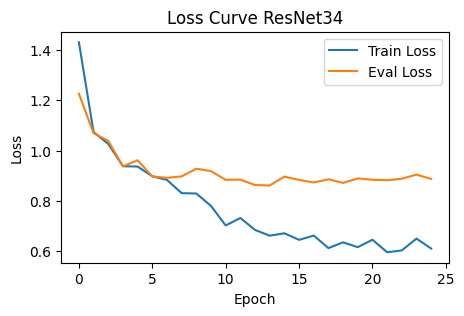

In [5]:
import matplotlib.pyplot as plt

loss = pd.DataFrame({
    'train_loss': tl,
    'eval_loss': el
})

plt.figure(figsize=(5, 3))
plt.plot(loss['train_loss'], label='Train Loss')
plt.plot(loss['eval_loss'], label='Eval Loss')
plt.title('Loss Curve ResNet34')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()